Implementing an Variational Autoencoder in PyTorch
===

First, to install PyTorch, you may use the following pip command,

```
$ pip install torch torchvision
```

The `torchvision` package contains the image data sets that are ready for use in PyTorch.

More details on its installation through [this guide](https://pytorch.org/get-started/locally/) from [pytorch.org](pytorch.org).

## Setup

We begin by importing our dependencies.

In [146]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from tqdm import tqdm
from torchvision.utils import save_image, make_grid

Set our seed and other configurations for reproducibility.

In [147]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

We set the batch size, the number of training epochs, and the learning rate.

In [148]:
batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset

We load our MNIST dataset using the `torchvision` package. 

In [149]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Variational Autoencoder

An Variational Autoencoder is a type of neural network that finds the function mapping the features x to itself. This objective is known as reconstruction, and an Variational Autoencoder accomplishes this through the following process: (2) an encoder learns the data representation in lower-dimension space, i.e. extracting the most salient features of the data, and (3) a decoder learns to reconstruct the original data based on the learned representation by the encoder.

We define our VAE class with fully connected layers for both its encoder and decoder components.

In [150]:
class Encoder(nn.Module):
    def __init__(self, input_shape, hidden_size, latent_size):
        super().__init__()

        self.hidden_encoder = nn.Linear(input_shape, hidden_size)
        self.mean = nn.Linear(hidden_size, latent_size)
        self.sd = nn.Linear(hidden_size, latent_size)
        
## input -> mean
#        |-> sd

    def forward(self, features):
        i = torch.relu(self.hidden_encoder(features))
        mean = self.mean(i)
        sd = self.sd(i)
        return mean, sd

In [151]:
class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_size, output_shape):
        super().__init__()
        self.hidden_decoder = nn.Linear(latent_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_shape) 

    def forward(self, features):
        i = torch.relu(self.hidden_decoder(features))
        outputs = torch.sigmoid(self.output(i))
        return outputs

In [152]:
class VAE(nn.Module):
    def __init__(self, Encoder, Decoder):
        super().__init__()
        self.encoder = Encoder
        self.decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
    
    def forward(self, features):
        mean, sd = self.encoder(features)
        z = self.reparameterization(mean, sd)
        outputs = self.decoder(z)
        return outputs, mean, sd

Before using our defined autoencoder class, we have the following things to do:
    1. We configure which device we want to run on.
    2. We instantiate an `AE` object.
    3. We define our optimizer.
    4. We define our reconstruction loss.

In [153]:
encoder = Encoder(input_shape=x_dim, hidden_size=hidden_dim, latent_size=latent_dim).to(DEVICE)
decoder = Decoder(latent_size=latent_dim, hidden_size=hidden_dim, output_shape=x_dim).to(DEVICE)
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = VAE(encoder, decoder).to(DEVICE)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=lr)

# mean-squared error loss

784


Define Loss Function

In [154]:
def loss_function(x, output, mean, sd):
    reproduction_loss = nn.functional.binary_cross_entropy(output, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + torch.log(sd**2) - mean**2 - sd**2)
    return reproduction_loss + KLD

We train our Variational Autoencoder for our specified number of epochs.

In [155]:
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, x_dim).to(DEVICE)
        x = batch_features.to(DEVICE) 
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs, mean, sd = model(x)
        
        # compute training reconstruction loss
        train_loss = loss_function(batch_features, outputs, mean, sd)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/30, recon loss = 19011.46855469
epoch : 2/30, recon loss = 13869.34686198
epoch : 3/30, recon loss = 12537.76618815
epoch : 4/30, recon loss = 11801.09989909
epoch : 5/30, recon loss = 11412.55937012
epoch : 6/30, recon loss = 11178.86482910
epoch : 7/30, recon loss = 11028.46462891
epoch : 8/30, recon loss = 10929.83419434
epoch : 9/30, recon loss = 10860.05511882
epoch : 10/30, recon loss = 10809.18916992
epoch : 11/30, recon loss = 10764.95883952
epoch : 12/30, recon loss = 10724.62055664
epoch : 13/30, recon loss = 10690.70353678
epoch : 14/30, recon loss = 10665.91617025
epoch : 15/30, recon loss = 10643.55765625
epoch : 16/30, recon loss = 10612.65591634
epoch : 17/30, recon loss = 10599.14139160
epoch : 18/30, recon loss = 10575.90136068
epoch : 19/30, recon loss = 10556.18574707
epoch : 20/30, recon loss = 10538.35290202
epoch : 21/30, recon loss = 10523.27416504
epoch : 22/30, recon loss = 10510.02664714
epoch : 23/30, recon loss = 10496.46093424
epoch : 24/30, recon

Let's extract some test examples to reconstruct using our trained autoencoder.

In [158]:
test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=False
)

test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, x_dim)
        reconstruction = model(test_examples)
        break

## Generate image

genrate image from test dataset

In [160]:
import matplotlib.pyplot as plt
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(-1, x_dim)
        x = x.to(DEVICE)
        output, _, _ = model(x)
        break

  0%|          | 0/1000 [00:00<?, ?it/s]


In [163]:
def show_image(x, idx):
    x = x.view(-1, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

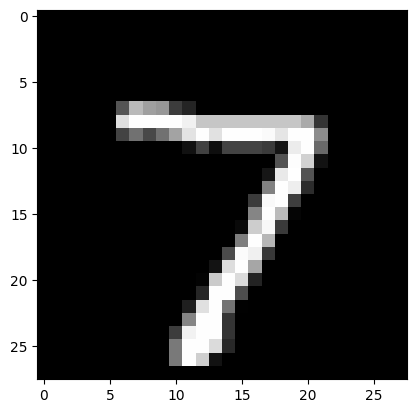

In [164]:
show_image(x, idx=0)

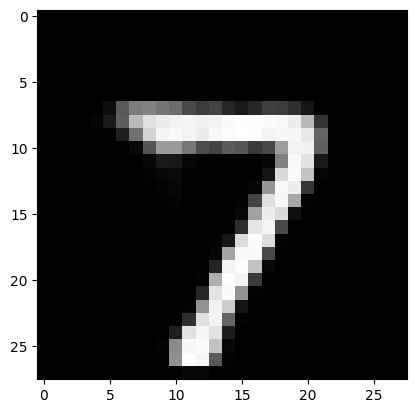

In [165]:
show_image(output, idx=0)

Generate image from noise vector

In [166]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [167]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

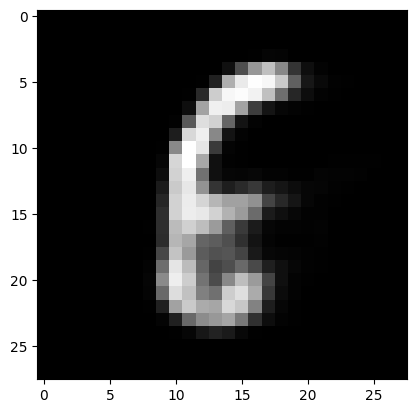

In [168]:
show_image(generated_images, idx=12)